# Problema de Négocio 

**A Empresa Cardio Catch Diseases ( CCD )**

A Cadio Catch Diseases é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O seu modelo de negócio é do tipo Serviço, ou seja, a empresa ofereço o diagnóstico precoce de uma doença cardiovascular por um certo preço.

Atualmente, o diagnóstico de uma doença cardiovascular é feita manualmente por uma equipe de especialistas. A precisão atual do diagnóstico varia entre 55% e 65%, devido a complexidade do diagnóstico e também da fadiga da equipe que se revezam em turnos para minimizar os riscos. O custo de cada diagnóstico, incluindo os aparelhos e a folha de pagamento dos analistas, gira em torno de R$ 1.000,00.

O preço do diagnóstico, pago pelo cliente, varia de acordo com a precisão conseguida pelo time de especialistas, o cliente paga 500 Reais a cada 5% de acurácia acima de 50%. Por exemplo, para uma precisão de 55%, o diagnóstico custa 500 reais para o cliente, para uma precisão de 60%, o valor é de R$ 1000,00 e assim por diante. Se a precisão do diagnóstico for 50%. o cliente não paga por ele.

Observe que a variação da precisão dada pelo time de especialistas, faz com que a empresa tenha ora uma operação com lucro, receita maior que o custo, ora uma operação com prejuízo, receita menor que o custo. Essa instabilidade do diagnóstico faz com que a empresa tenha um Cashflow imprevisível.

O seu objetivo como o Cientista de Dados contratado pela Cardio Catch Diseases é criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos.

Portanto o seu trabalho como Data Scientist é criar um ferramenta de classificação de doentes, como uma precisão estável. Junto com a ferramenta, você precisa enviar um relatório para o CEO da Cardio Catch Diseases, reportando os resultados e respondendo às seguintes perguntas: ( Ele provavelmente irá fazer essas pergunta no dia da sua apresentação. )

- Qual a Acurácia e a Precisão da ferramenta?
- Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
- Qual a Confiabilidade do resultado dados pela nova ferramenta?

# 0.0 Importações 

In [1]:
import pandas             as pd
import seaborn            as sns
import matplotlib.pyplot  as plt
import scikitplot         as skplt
import numpy              as np
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics         import roc_auc_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from IPython.display         import Image
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble        import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from lightgbm                import LGBMClassifier
from boruta                  import BorutaPy
from sklearn.metrics         import plot_confusion_matrix

## 0.1 Funções

In [2]:
def obesity(coluna):
    if coluna <= 18.5:
        return 'Baixo Peso'
    elif coluna >18.5 and coluna <=24.9:
        return 'Peso Normal'
    elif coluna >25 and coluna <=29.9:
        return 'Pré Obeso'
    elif coluna >30 and coluna <=34.9:
        return 'Obesidade I'
    elif coluna >35 and coluna <=39.9:
        return 'Obesidade II'
    else:
        return 'Obesidade III'

In [3]:
def factors_risk_active(cols):
    sum_of_factors = cols[0]
    active = cols[1]
    
    if sum_of_factors > 3 and active == 0:
        return 'Não faz atividade - 2 comorbidade'
    if sum_of_factors == 3 and active == 0:
        return 'Não faz atividade - 1 comorbidade'
    if sum_of_factors == 2 and active == 0:
        return 'Não faz atividade - Nenhuma comorbidade'
    if sum_of_factors > 3 and active == 1:
        return 'Faz atividade - 2 comorbidade'
    if sum_of_factors == 3 and active == 1:
        return 'Faz atividade - 1 comorbidade'
    else:
        return 'Faz atividade - Nenhuma comorbidade'

In [4]:
def bad_habits_active(cols):
    bad_habits = cols[0]
    active = cols[1]
    
    if bad_habits == 2 and active == 0:
        return 'Não faz atividade - 2 maus hábitos'
    if bad_habits == 1 and active == 0:
        return 'Não faz atividade - 1 mau hábitos'
    if bad_habits == 0 and active == 0:
        return 'Não faz atividade - Nenhum mau hábitos'
    if bad_habits == 2 and active == 1:
        return 'Faz atividade - 2 maus hábitos'
    if bad_habits == 1 and active == 1:
        return 'Faz atividade - 1 mau hábitos'
    else:
        return 'Faz atividade - Nenhum mau hábitos'

In [5]:
# Função para calculo de métricas dos Modelos.
def ml_error(model_name,modelo, X_train, y_train):
    scoring = {'accuracy' : make_scorer(accuracy_score), 
               'precision' : make_scorer(precision_score),
               'recall' : make_scorer(recall_score), 
               'f1_score' : make_scorer(f1_score)}
    
    
    kfold = KFold(n_splits=5)
    model = modelo 
    
    scores = cross_validate(estimator=model, X=X_train, y=y_train, cv=kfold,scoring=scoring)
    
    return pd.DataFrame({'Model_Name':model_name,
                        'Acuracia':(scores['test_accuracy'].mean()),
                        'Precision': (scores['test_precision'].mean()),
                        'Recall': (scores['test_recall'].mean()),
                        'F1':(scores['test_f1_score'].mean())},index=[0])                                                                                 

In [6]:
# Multiplas Matriz de Confusão.
def multiple_confusion_matrix(classifiers, X_train, X_test):
    for cls in classifiers:
        cls.fit(X_train, y_train)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

    for cls, ax in zip(classifiers, axes.flatten()):
        plot_confusion_matrix(cls, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Greens', normalize='true')
        ax.title.set_text(type(cls).__name__)  

    plt.tight_layout()  
    plt.show()

# 1.0 - Análise Descritiva

In [7]:
df = pd.read_csv('cardio_train.csv', sep = ";")

In [8]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [9]:
df.shape

(70000, 13)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


## 1.2 Verificando valores faltantes

In [12]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

# 2.0 Feature Engineering

In [13]:
# conversão de dias da idade para anos
df['age'] = df['age'].apply( lambda x: round(x/365))

# soma dos fatores de risco
df['sum of factors'] = df['cholesterol'] + df['gluc']

# soma dos maus hábitos 
df['bad habits'] = df['smoke'] + df['alco']

# Influência da atividade física nos fatores de risco
df['influence comorbid activities'] = df[['sum of factors', 'active']].apply(factors_risk_active, axis=1)

# Influencia da atividade física nos maus hábitos
df['influence bad habits activities'] = df[['bad habits', 'active']].apply(bad_habits_active, axis=1)

# Calculando IMC
df['imc'] = df['weight'] / ((df['height']/100) * (df['height']/100))

#Calculando grau de obesidade
df['obesity'] = df['imc'].apply(obesity)

#Pressão alta dividida por pressão baixa
df['hi_per_low'] = df['ap_hi'] / df['ap_lo']

In [14]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,sum of factors,bad habits,influence comorbid activities,influence bad habits activities,imc,obesity,hi_per_low
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,2,0,Faz atividade - Nenhuma comorbidade,Faz atividade - Nenhum mau hábitos,21.967120,Peso Normal,1.375000
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,4,0,Faz atividade - 2 comorbidade,Faz atividade - Nenhum mau hábitos,34.927679,Obesidade III,1.555556
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,4,0,Não faz atividade - 2 comorbidade,Não faz atividade - Nenhum mau hábitos,23.507805,Peso Normal,1.857143
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,2,0,Faz atividade - Nenhuma comorbidade,Faz atividade - Nenhum mau hábitos,28.710479,Pré Obeso,1.500000
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,2,0,Não faz atividade - Nenhuma comorbidade,Não faz atividade - Nenhum mau hábitos,23.011177,Peso Normal,1.666667


# 2.0 Mapa Mental de hipoteses 

## 2.1 Mapa mental

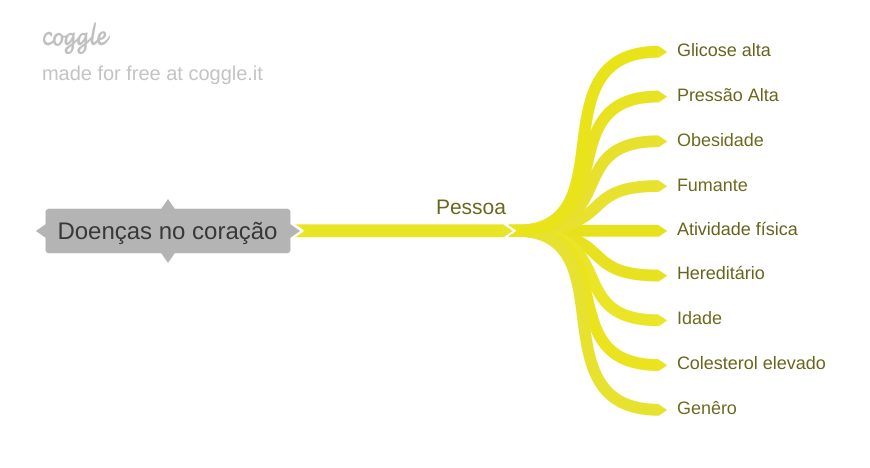

In [15]:
Image ('img\Doenas_no_corao.png')

## Hipoteses

**H1** - Pessoas com mais de 60 anos tem duas vezes mais chances de ter problema no coração do que uma pessoa com menos de 60 anos.

**H2** - Em média, um gênero tem mais chances de ter problema no coração do que o outro.

**H3** - Pressão alta acima de 140 aumenta duas vezes o risco de ter problema no coração.

**H4** - Pressão baixa acima de 80 aumenta duas vezes o risco de ter problema no coração.

**H5** - Colesterol alto é um fator importante para problemas no coração.

**H6** - Pessoas que fumam tem 2 vezes mais chances de ter um problema no coração.

**H7** - O Alcool não é um fator importante para quem doenças no coração.

**H8** - Pessoas ativas tem menos chances de desenvolver um  problema no coração.

**H9** - Pessoas que acumulam Colesterol e/ou Glicose e/ou fumam e/ou bebem tem o dobro de pessoas que não tem essas características.

**H10** - Pessoas com grau de obesidade acima de 2 tem duas vezes mais chances de ter problema no coração.

# 3.0 Análise exploratória

##  3.1 - Análise Univariada

### 3.1.0 -  Variável Resposta - Cardio

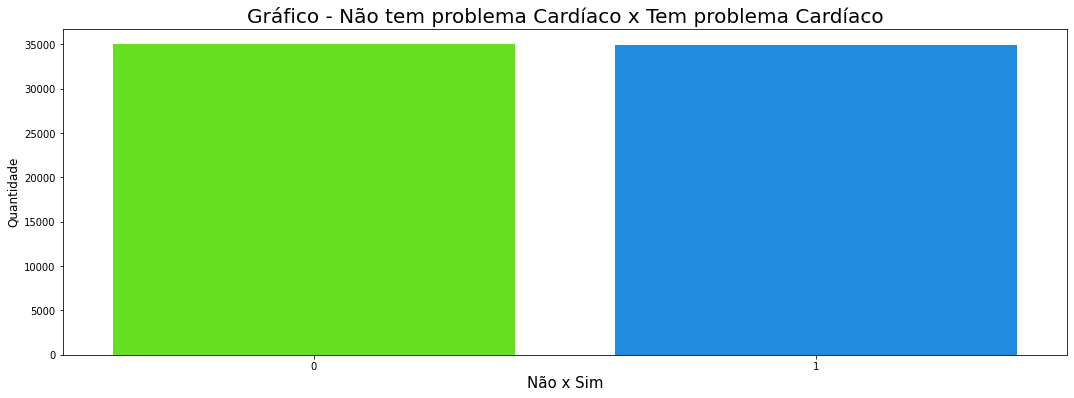

In [16]:
# Variável resposta
plt.figure(figsize=(18,6))
sns.countplot(x='cardio', data=df, palette='gist_rainbow');
plt.title('Gráfico - Não tem problema Cardíaco x Tem problema Cardíaco', fontsize=20)
plt.xlabel("Não x Sim", fontsize=15)
plt.ylabel("Quantidade", fontsize=12);

**Anotações Importantes**

- Os dados estão balanceados.

### 3.1.1 - Variável  Age - Idade

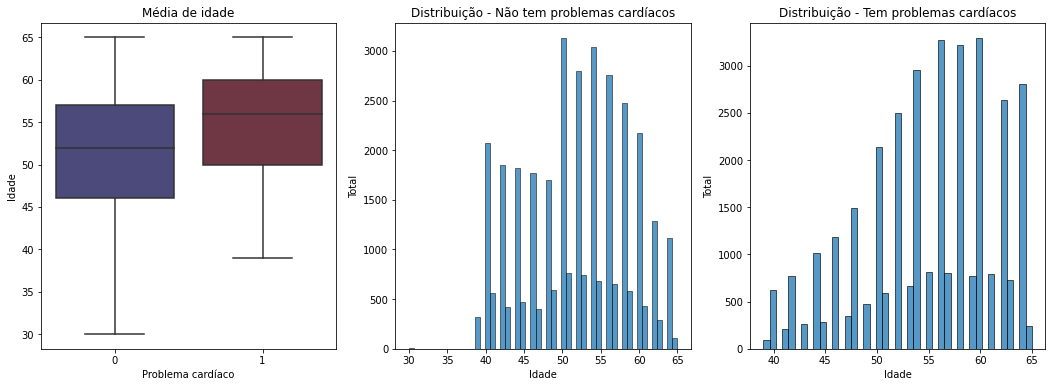

In [17]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot(x='cardio', y='age', data=df, palette='icefire');
plt.title('Média de idade')
plt.xlabel("Problema cardíaco")
plt.ylabel("Idade")

plt.subplot(1,3,2)
aux00 = df.loc[df['cardio'] == 0, 'age']
sns.histplot(aux00, palette='icefire')
plt.title('Distribuição - Não tem problemas cardíacos')
plt.xlabel("Idade")
plt.ylabel("Total")

plt.subplot(1,3,3)
aux00 = df.loc[df['cardio'] == 1, 'age']
sns.histplot(aux00, palette='icefire');
plt.title('Distribuição - Tem problemas cardíacos')
plt.xlabel("Idade")
plt.ylabel("Total");

**Anotações Importantes**

- Os pacientes que possuem doenças cardíacas possuem uma média de idade maior do que os pacientes que não possuem.

### 3.1.2 - Variável Gender - Gênero

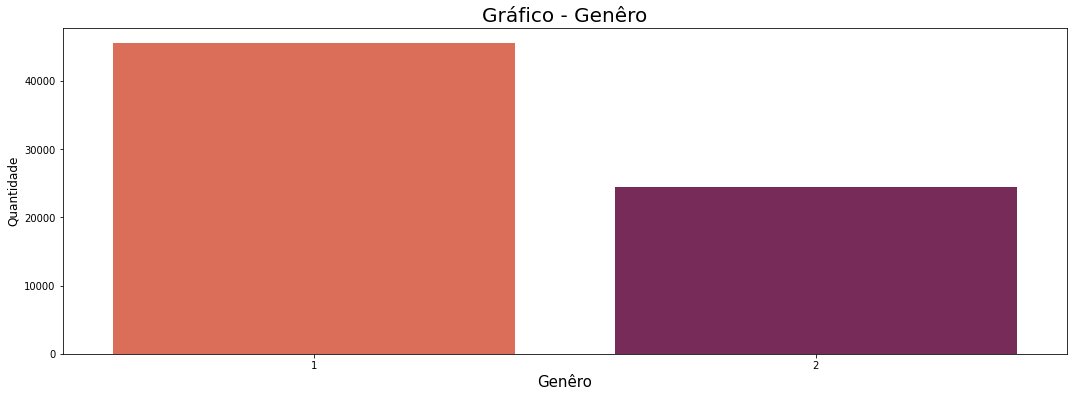

In [18]:
plt.figure(figsize=(18,6))
sns.countplot(x='gender', data=df, palette='rocket_r');
plt.title('Gráfico - Genêro', fontsize=20)
plt.xlabel("Genêro", fontsize=15)
plt.ylabel("Quantidade", fontsize=12);

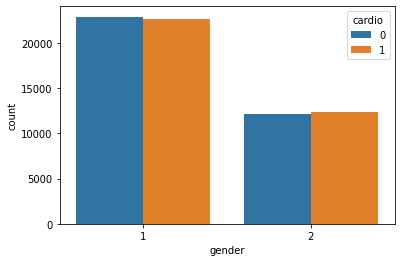

In [19]:
sns.countplot(x='gender', hue='cardio', data=df);

**Anotações Importantes**

- O dataset tem mais exemplos de um dos genêros. 

### 3.1.3 - Variável Weight - Peso

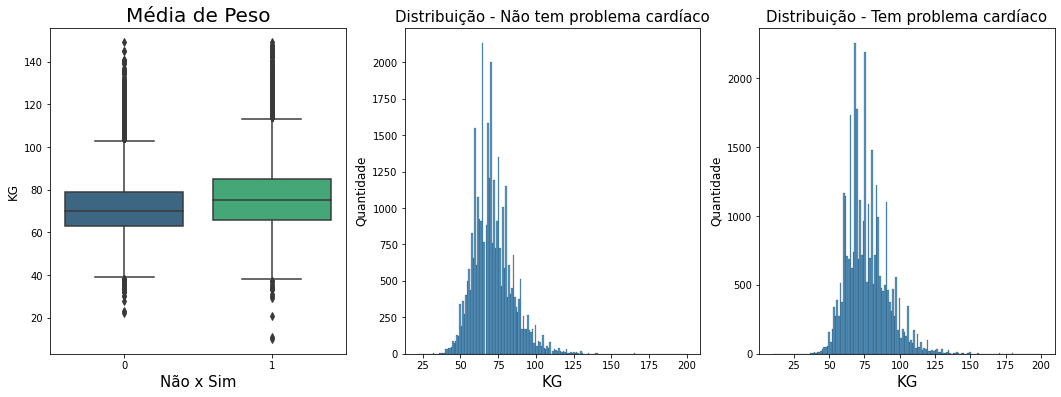

In [20]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
aux = df[df['weight'] < 150]
sns.boxplot(x='cardio', y='weight', data=aux, palette='viridis');
plt.title('Média de Peso', fontsize=20)
plt.xlabel("Não x Sim", fontsize=15)
plt.ylabel("KG", fontsize=12);

plt.subplot(1,3,2)
aux00 = df.loc[df['cardio'] == 0, 'weight']
sns.histplot(aux00)
plt.title('Distribuição - Não tem problema cardíaco', fontsize=15)
plt.xlabel("KG", fontsize=15)
plt.ylabel("Quantidade", fontsize=12);

plt.subplot(1,3,3)
aux00 = df.loc[df['cardio'] == 1, 'weight']
sns.histplot(aux00);
plt.title('Distribuição - Tem problema cardíaco', fontsize=15)
plt.xlabel("KG", fontsize=15)
plt.ylabel("Quantidade", fontsize=12);


**Anotações Importantes**

- Parece haver Outlier na varíavel Weight.
- Media dos KG de quem tem problema no coração é maior.
- A Distribuição de quem tem problemas cardíacos e de quem não tem problemas cardíacos parece igual.

### 3.1.4 - Variável Height - Altura

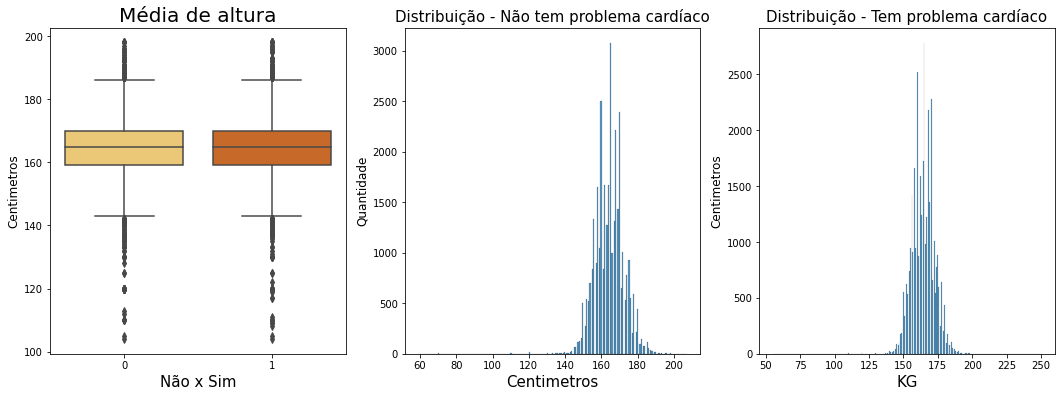

In [21]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
aux = df[(df['height'] >100) & (df['height'] < 200)]
sns.boxplot(x='cardio', y='height', data=aux, palette='YlOrBr');
plt.title('Média de altura', fontsize=20)
plt.xlabel("Não x Sim", fontsize=15)
plt.ylabel("Centimetros", fontsize=12);

plt.subplot(1,3,2)
aux00 = df.loc[df['cardio'] == 0, 'height']
sns.histplot(aux00)
plt.title('Distribuição - Não tem problema cardíaco', fontsize=15)
plt.xlabel("Centimetros", fontsize=15)
plt.ylabel("Quantidade", fontsize=12);

plt.subplot(1,3,3)
aux00 = df.loc[df['cardio'] == 1, 'height']
sns.histplot(aux00);
plt.title('Distribuição - Tem problema cardíaco', fontsize=15)
plt.xlabel("KG", fontsize=15)
plt.ylabel("Centimetros", fontsize=12);

**Anotações Importantes**

- Parece haver Outlier na varíavel Height.
- A Media da altura de quem tem problema no coração é igual.
- A Distribuição de quem tem problemas cardíacos e de quem não tem problemas cardíacos parece igual.

### 3.1.5 - Variáveis ap_hi, ap_lo e age - Pressão alta, Pressão Baixa e Idade

**Filtrar apenas quem tem pressão alta entre 0 e 200 e quem tem pressão baixa entre 0 e 130.**

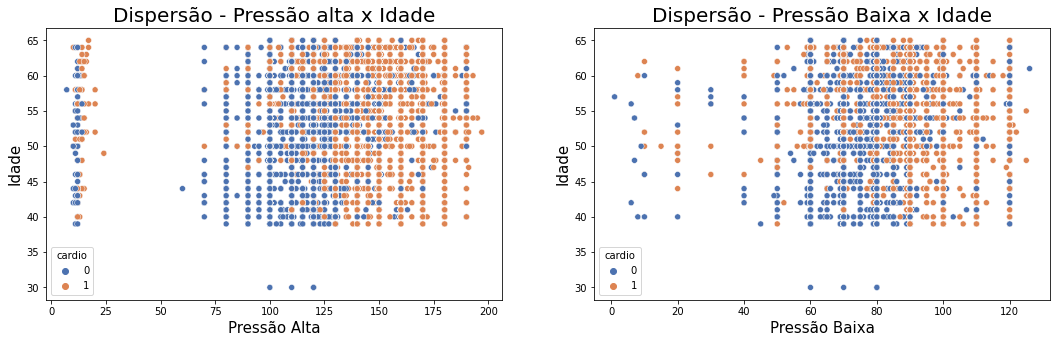

In [22]:
df1 = df[(df['ap_hi']>0) & (df['ap_hi']<200) & (df['ap_lo']>0) & (df['ap_lo']<130)]
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.scatterplot(x='ap_hi', y='age', hue='cardio', data=df1, palette='deep');
plt.title('Dispersão - Pressão alta x Idade', fontsize=20)
plt.xlabel("Pressão Alta", fontsize=15)
plt.ylabel("Idade", fontsize=15);


plt.subplot(1,2,2)
sns.scatterplot(x='ap_lo', y='age', hue='cardio', data=df1, palette='deep');
plt.title('Dispersão - Pressão Baixa x Idade', fontsize=20)
plt.xlabel("Pressão Baixa", fontsize=15)
plt.ylabel("Idade", fontsize=15);

**Anotações Importantes**

- Parece haver outliers na variável Pressão Alta mesmo que filtrada. (Entre 0 e 50)
- Parece haver outliers na variável Pressão baixa mesmo que filtrada. (Entre 0 e 40)
- Quem tem pressão alta maior parece ter mais chances de ter problemas no coração.
- Quem tem uma idade mais alta tem mais chances de ter problemas no coração.
- Quem tem uma pressão baixa menor e uma idade menor tem mais chances de NÃO ter problemas no coração. 

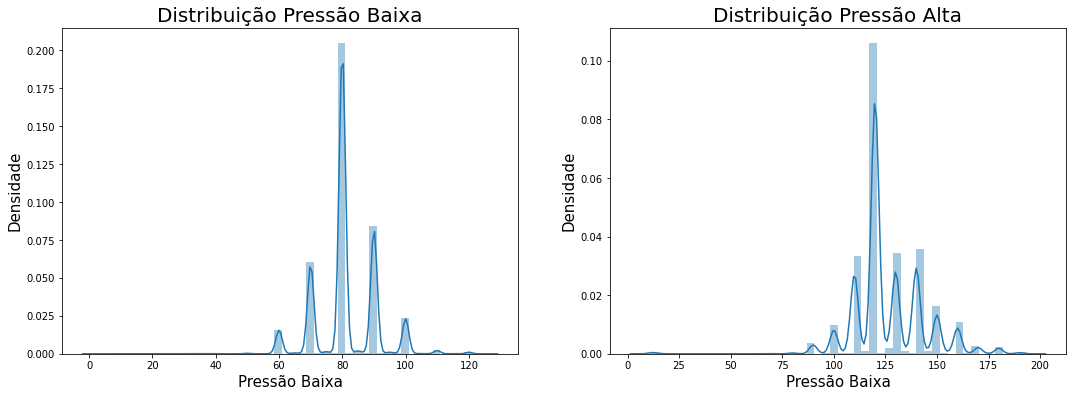

In [23]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.distplot(df1['ap_lo']);
plt.title('Distribuição Pressão Baixa', fontsize=20)
plt.xlabel("Pressão Baixa", fontsize=15)
plt.ylabel("Densidade", fontsize=15);

plt.subplot(1,2,2)
sns.distplot(df1['ap_hi']);
plt.title('Distribuição Pressão Alta', fontsize=20)
plt.xlabel("Pressão Baixa", fontsize=15)
plt.ylabel("Densidade", fontsize=15);

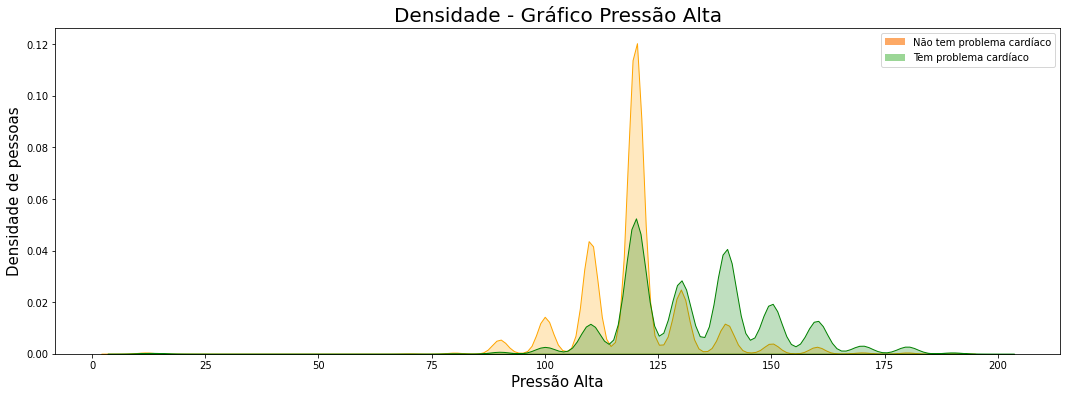

In [24]:
plt.figure(figsize=(18,6))
sns.kdeplot(df1[df1['cardio']==0]['ap_hi'], shade=True, color='orange')
sns.kdeplot(df1[df1['cardio']==1]['ap_hi'], shade=True, color='green')
handles = [mpatches.Patch(facecolor=plt.cm.Oranges(100), label="Não tem problema cardíaco"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="Tem problema cardíaco")]
plt.legend(handles=handles);
plt.title('Densidade - Gráfico Pressão Alta', fontsize=20)
plt.xlabel("Pressão Alta", fontsize=15)
plt.ylabel("Densidade de pessoas", fontsize=15);

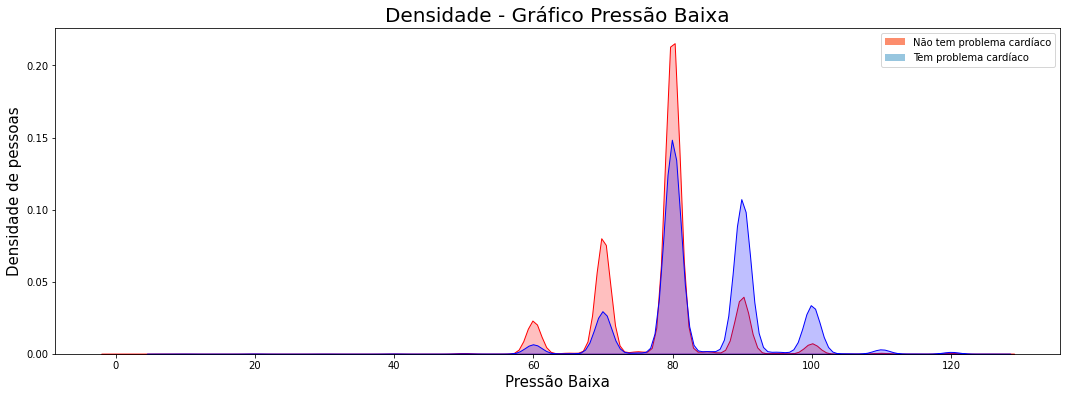

In [25]:
plt.figure(figsize=(18,6))
sns.kdeplot(df1[df1['cardio']==0]['ap_lo'], shade=True, color='red')
sns.kdeplot(df1[df1['cardio']==1]['ap_lo'], shade=True, color='blue')
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Não tem problema cardíaco"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Tem problema cardíaco")]
plt.legend(handles=handles);
plt.title('Densidade - Gráfico Pressão Baixa', fontsize=20)
plt.xlabel("Pressão Baixa", fontsize=15)
plt.ylabel("Densidade de pessoas", fontsize=15);


**Anotações Importantes**

- Quem tem problemas cardíacos tem semmpre pressão alta e pressão baixa maior dos que não tem.

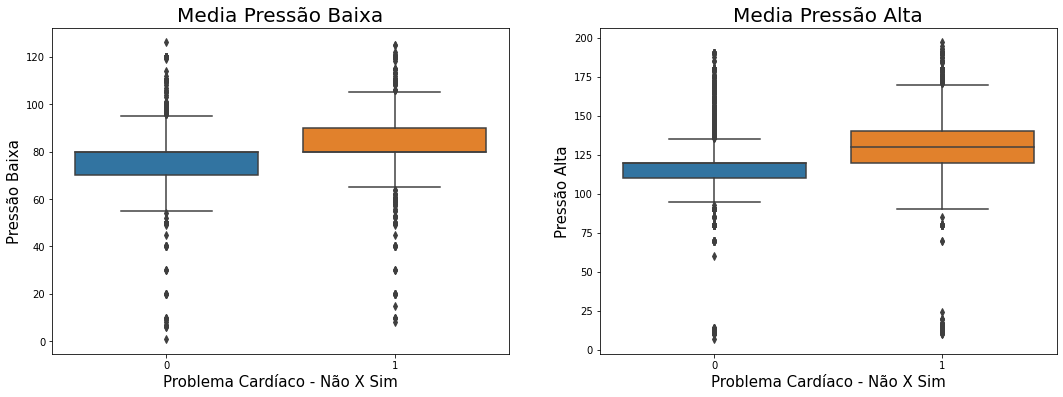

In [26]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.boxplot(x='cardio', y='ap_lo', data=df1);
plt.title('Media Pressão Baixa', fontsize=20)
plt.xlabel("Problema Cardíaco - Não X Sim", fontsize=15)
plt.ylabel("Pressão Baixa", fontsize=15);

plt.subplot(1,2,2)
sns.boxplot(x='cardio', y='ap_hi', data=df1);
plt.title('Media Pressão Alta', fontsize=20)
plt.xlabel("Problema Cardíaco - Não X Sim", fontsize=15)
plt.ylabel("Pressão Alta", fontsize=15);

**Anotações Importantes**

- Quem tem problemas cardíacos tem uma pressão alta e uma pressão baixa maior em média.
- Outliers em ap_hi e ap_ho.

### 3.1.6 - Variável Cholesterol - Colesterol

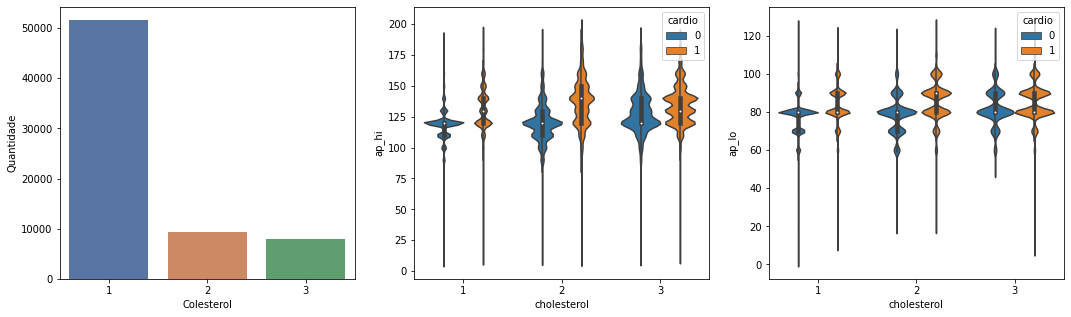

In [27]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x = 'cholesterol', data=df1,palette='deep')
plt.xlabel('Colesterol')
plt.ylabel('Quantidade');

plt.subplot(1,3,2)
sns.violinplot(x='cholesterol', y='ap_hi', hue='cardio', data=df1);
               
plt.subplot(1,3,3)
sns.violinplot(x='cholesterol', y='ap_lo', hue='cardio', data=df1);

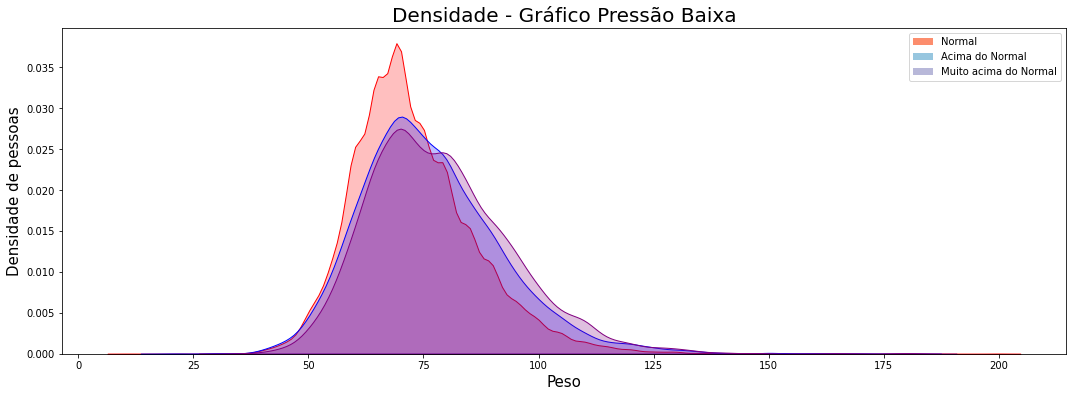

In [28]:
plt.figure(figsize=(18,6))
sns.kdeplot(df1[df1['cholesterol']==1]['weight'], shade=True, color='red')
sns.kdeplot(df1[df1['cholesterol']==2]['weight'], shade=True, color='blue')
sns.kdeplot(df1[df1['cholesterol']==3]['weight'], shade=True, color='purple')
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Normal"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Acima do Normal"),
           mpatches.Patch(facecolor=plt.cm.Purples(100), label="Muito acima do Normal")]
plt.legend(handles=handles);
plt.title('Densidade - Gráfico Pressão Baixa', fontsize=20)
plt.xlabel("Peso", fontsize=15)
plt.ylabel("Densidade de pessoas", fontsize=15);


In [29]:
# Poucas pessoas com Colesterol normal e pressão alta tem problemas no coração.
# Pessoas que possuem colesterol fora do normal, a pressão alta é um fator de risco.
# Pessoas que possuem colesterol muito fora do normal, a pressão alta é um fator de risco
# Pressão alta parece estar fortemente ligada aos fatores de risco.

### 3.1.7 - Variável Gluc - Glicose

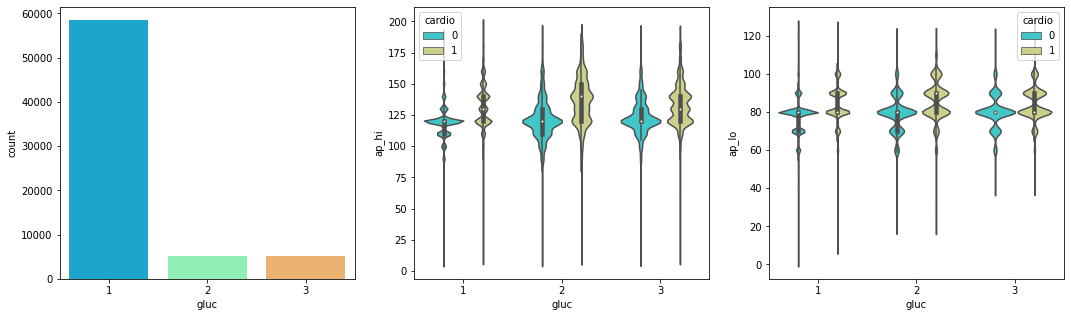

In [30]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x='gluc', data=df1, palette='rainbow');

plt.subplot(1,3,2)
sns.violinplot(x='gluc', y='ap_hi', hue='cardio', data=df1, palette='rainbow')

plt.subplot(1,3,3)
sns.violinplot(x='gluc', y='ap_lo', hue='cardio', data=df1, palette='rainbow');

### 3.1.8 - Variável Smoke - Cigarro

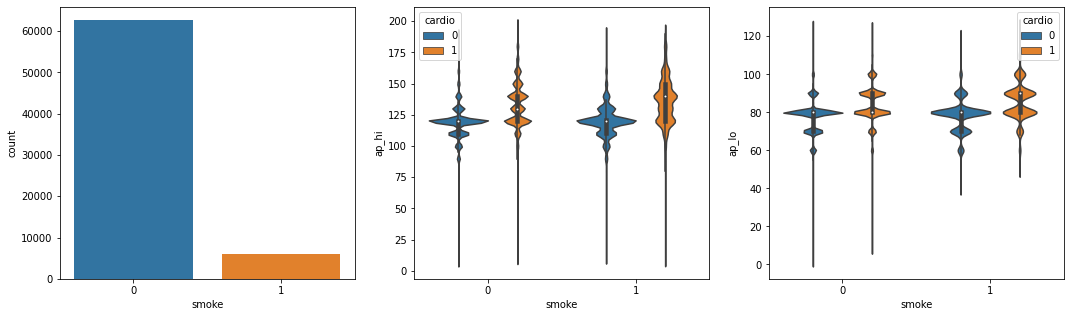

In [31]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x='smoke', data=df1);

plt.subplot(1,3,2)
sns.violinplot(x='smoke', y='ap_hi', hue='cardio', data=df1);

plt.subplot(1,3,3)
sns.violinplot(x='smoke', y='ap_lo', hue='cardio', data=df1);

### 3.1.9 Variável Alco - Álcool

A Grande maioria das pessoas da base de dados não bebem alcool.

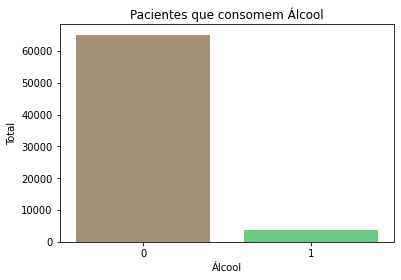

In [32]:
sns.countplot(x='alco', data=df1, palette='terrain_r');
plt.title('Pacientes que consomem Álcool')
plt.xlabel('Álcool')
plt.ylabel('Total');

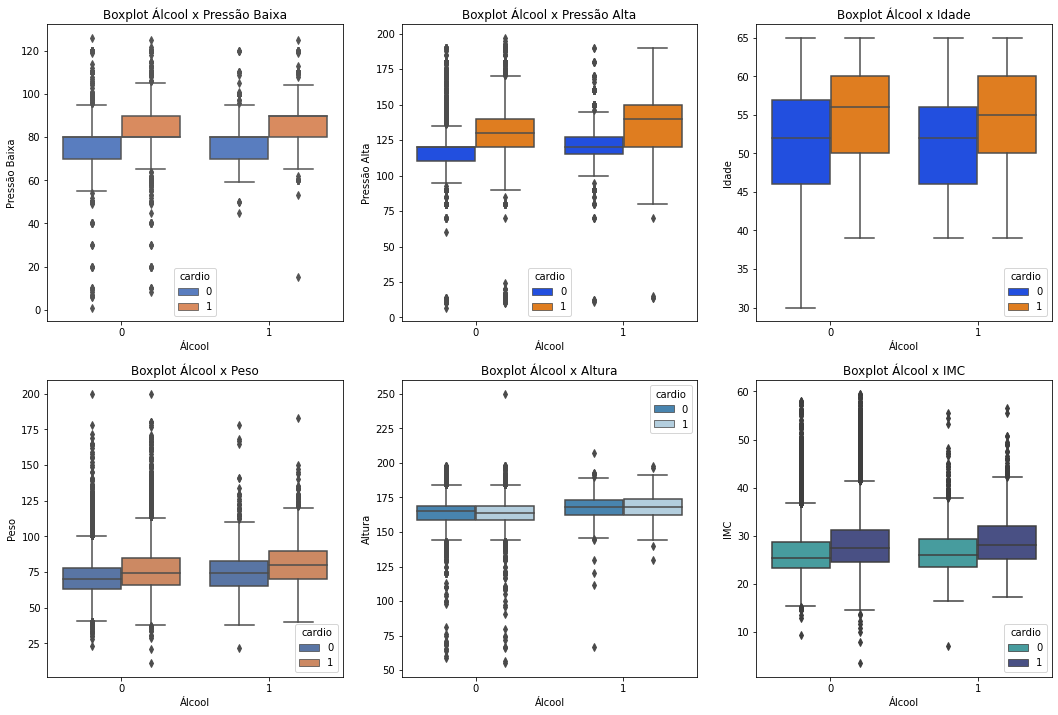

In [33]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
sns.boxplot(x='alco', y='ap_lo', hue='cardio', data=df1, palette='muted');
plt.title('Boxplot Álcool x Pressão Baixa')
plt.xlabel('Álcool')
plt.ylabel('Pressão Baixa');

plt.subplot(2,3,2)
sns.boxplot(x='alco', y='ap_hi', hue='cardio', data=df1, palette='bright');
plt.title('Boxplot Álcool x Pressão Alta')
plt.xlabel('Álcool')
plt.ylabel('Pressão Alta');

plt.subplot(2,3,3)
sns.boxplot(x='alco', y='age', hue='cardio', data=df1, palette='bright');
plt.title('Boxplot Álcool x Idade')
plt.xlabel('Álcool')
plt.ylabel('Idade');

plt.subplot(2,3,4)
sns.boxplot(x='alco', y='weight', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Álcool x Peso')
plt.xlabel('Álcool')
plt.ylabel('Peso');

plt.subplot(2,3,5)
sns.boxplot(x='alco', y='height', hue='cardio', data=df1, palette='Blues_r');
plt.title('Boxplot Álcool x Altura')
plt.xlabel('Álcool')
plt.ylabel('Altura');

plt.subplot(2,3,6)
aux = df1[(df['imc']<60)]
sns.boxplot(x='alco', y='imc', hue='cardio', data=aux, palette='mako_r');
plt.title('Boxplot Álcool x IMC')
plt.xlabel('Álcool')
plt.ylabel('IMC');

- Poucas pessoas da base de dados consomem alcool, então essa varíavel sozinha não parece ter efeito em doenças no coração.

- Quem tem doença no coração normalmente tem: Mais idade, uma maior pressão alta, uma maior pressão baixa e mais peso.

- A altura não parece influenciar em nada sozinha.

### 3.1.10 - Variável Active - Atividade Física

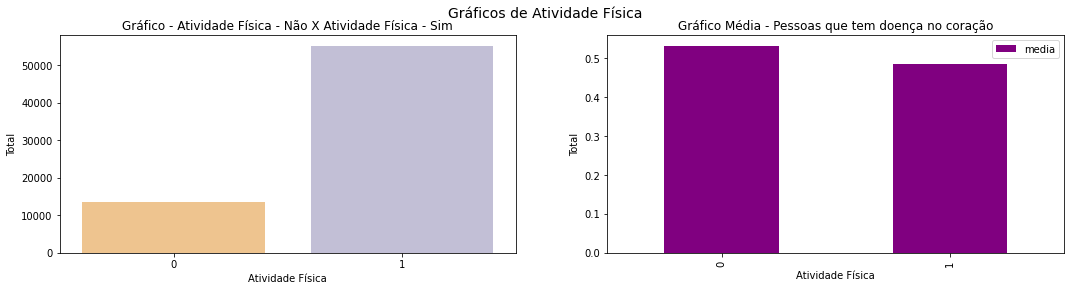

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
sns.countplot(x='active', data=df1, ax=ax[0], palette="PuOr");
ax[0].set_title('Gráfico - Atividade Física - Não X Atividade Física - Sim')
ax[0].set_xlabel('Atividade Física')
ax[0].set_ylabel('Total')
fig.suptitle('Gráficos de Atividade Física', fontsize=14)

df2 = df1[['active', 'cardio']].groupby('active').count().reset_index()
hue0 = df1[(df1['active']==0) & (df1['cardio']==1)].shape[0]
hue1 = df1[(df1['active']==1) & (df1['cardio']==1)].shape[0]
hue = pd.DataFrame([hue0, hue1])
df3 = pd.concat([df2, hue], axis=1)
df3['media'] = df3[0]/df3['cardio']
df3 = df3[['active', 'media']]
df3.set_index('active',inplace=True)
df3.plot.bar(ax=ax[1], color='purple');
ax[1].set_title('Gráfico Média - Pessoas que tem doença no coração')
ax[1].set_xlabel('Atividade Física')
ax[1].set_ylabel('Total');

A Grande maioria das pessoas do dataset fazem atividade física, porém em média, quem tem doença no coração não faz atividade física. Isso por si só não explica muita coisa, pois quem tem doença no coração pode não fazer atividade por outros motivos como obesidade, idade, etc.

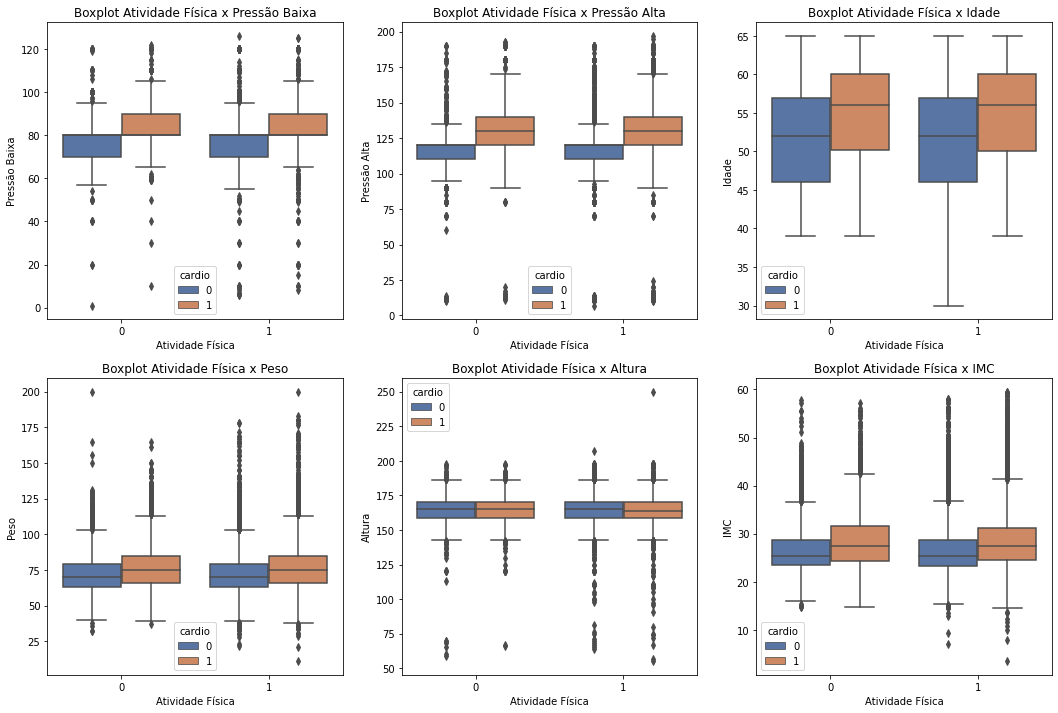

In [35]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
sns.boxplot(x='active', y='ap_lo', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Pressão Baixa')
plt.xlabel('Atividade Física')
plt.ylabel('Pressão Baixa');

plt.subplot(2,3,2)
sns.boxplot(x='active', y='ap_hi', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Pressão Alta')
plt.xlabel('Atividade Física')
plt.ylabel('Pressão Alta');

plt.subplot(2,3,3)
sns.boxplot(x='active', y='age', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Idade')
plt.xlabel('Atividade Física')
plt.ylabel('Idade');

plt.subplot(2,3,4)
sns.boxplot(x='active', y='weight', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Peso')
plt.xlabel('Atividade Física')
plt.ylabel('Peso');

plt.subplot(2,3,5)
sns.boxplot(x='active', y='height', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Altura')
plt.xlabel('Atividade Física')
plt.ylabel('Altura');

plt.subplot(2,3,6)
aux = df1[(df['imc']<60)]
sns.boxplot(x='active', y='imc', hue='cardio', data=aux, palette='deep');
plt.title('Boxplot Atividade Física x IMC')
plt.xlabel('Atividade Física')
plt.ylabel('IMC');

### 3.1.11 - Variável Influence Comorbid Activities - Influência da atividade física em quem tem comorbidades

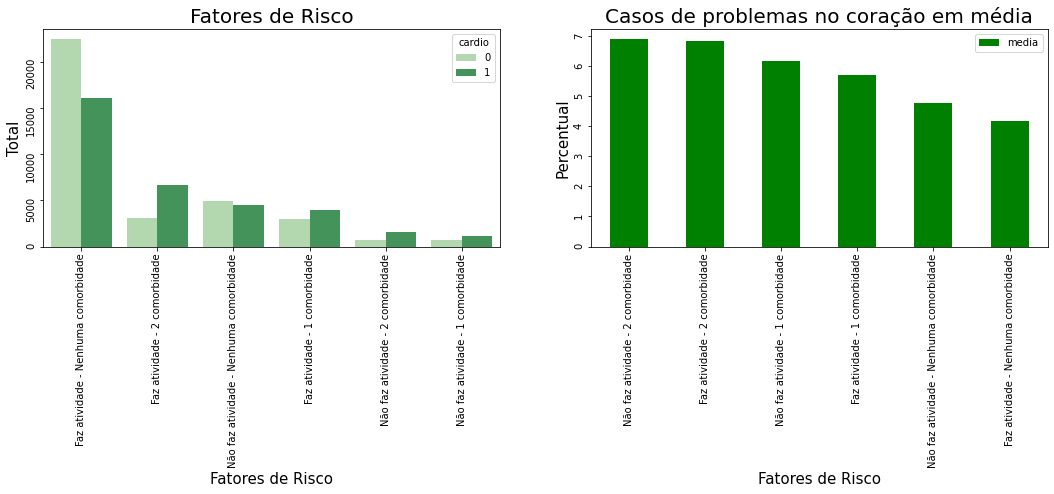

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
sns.countplot(x='influence comorbid activities', hue='cardio', data=df1, palette='Greens', ax=ax[0], 
              order = df1['influence comorbid activities'].value_counts().index);
ax[0].set_title('Fatores de Risco', fontsize=20)
ax[0].set_xlabel('Fatores de Risco', fontsize=15)
ax[0].tick_params(labelrotation=90)
ax[0].set_ylabel('Total', fontsize=15);

aux = df1[['influence comorbid activities', 'cardio']].groupby('influence comorbid activities').count().reset_index()
hue1 = df1[(df1['influence comorbid activities']=='Não faz atividade - 2 comorbidade') & (df1['cardio']==1)].shape[0]
hue2 = df1[(df1['influence comorbid activities']=='Não faz atividade - 1 comorbidade') & (df1['cardio']==1)].shape[0]
hue3 = df1[(df1['influence comorbid activities']=='Não faz atividade - Nenhuma comorbidade') & (df1['cardio']==1)].shape[0]
hue4 = df1[(df1['influence comorbid activities']=='Faz atividade - 2 comorbidade') & (df1['cardio']==1)].shape[0]
hue5 = df1[(df1['influence comorbid activities']=='Faz atividade - 1 comorbidade') & (df1['cardio']==1)].shape[0]
hue6 = df1[(df1['influence comorbid activities']=='Faz atividade - Nenhuma comorbidade') & (df1['cardio']==1)].shape[0]
hue = pd.DataFrame([hue5, hue4, hue6, hue2, hue1, hue3])
aux1 = pd.concat([aux, hue], axis=1)
aux1['media'] = aux1[0]/aux1['cardio']
aux1['media'] = aux1['media']*10
aux1 = aux1[['influence comorbid activities', 'media']]
aux1.set_index('influence comorbid activities',inplace=True)
aux1 = aux1.sort_values(by='media', ascending=False)
aux1.plot.bar(ax=ax[1], color='Green');
ax[1].set_title('Casos de problemas no coração em média', fontsize=20)
ax[1].set_xlabel('Fatores de Risco', fontsize=15)
ax[1].tick_params(labelrotation=90)
ax[1].set_ylabel('Percentual', fontsize=15);

**Anotações Importantes**

- Para um mesmo número de comorbidade a atividade física parece fazer diferença (mesmo que pouca).
- É melhor não ter comorbidades do que fazer atividades físicas.

### 3.1.12 - Variável influence bad habits activities - Influência da atividade física em quem tem maus hábitos 

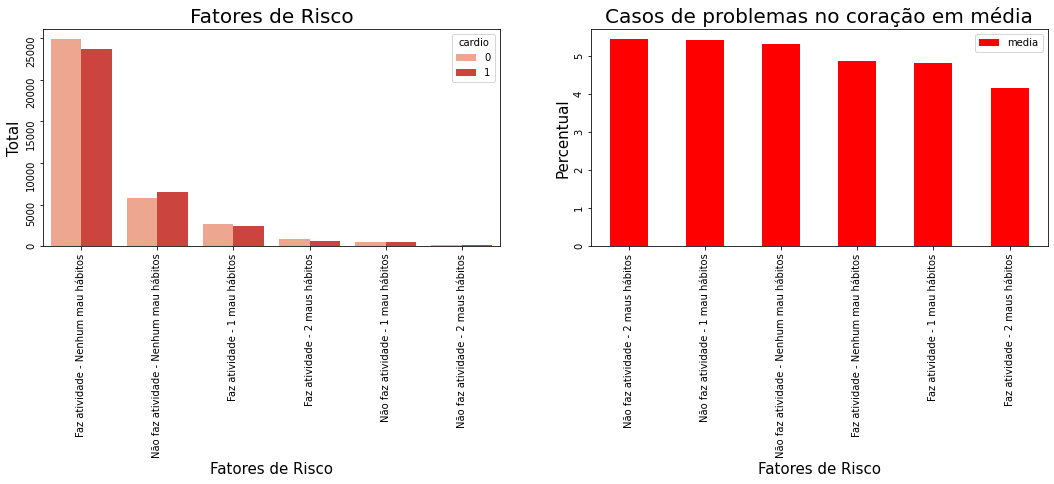

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
sns.countplot(x='influence bad habits activities', hue='cardio', data=df1, ax=ax[0], palette= "Reds",
             order = df1['influence bad habits activities'].value_counts().index);
ax[0].set_title('Fatores de Risco', fontsize=20)
ax[0].set_xlabel('Fatores de Risco', fontsize=15)
ax[0].tick_params(labelrotation=90)
ax[0].set_ylabel('Total', fontsize=15)

aux = df1[['influence bad habits activities', 'cardio']].groupby('influence bad habits activities').count().reset_index()
hue1 = df1[(df1['influence bad habits activities']=='Não faz atividade - 2 maus hábitos') & (df1['cardio']==1)].shape[0]
hue2 = df1[(df1['influence bad habits activities']=='Não faz atividade - 1 mau hábitos') & (df1['cardio']==1)].shape[0]
hue3 = df1[(df1['influence bad habits activities']=='Não faz atividade - Nenhum mau hábitos') & (df1['cardio']==1)].shape[0]
hue4 = df1[(df1['influence bad habits activities']=='Faz atividade - 2 maus hábitos') & (df1['cardio']==1)].shape[0]
hue5 = df1[(df1['influence bad habits activities']=='Faz atividade - 1 mau hábitos') & (df1['cardio']==1)].shape[0]
hue6 = df1[(df1['influence bad habits activities']=='Faz atividade - Nenhum mau hábitos') & (df1['cardio']==1)].shape[0]
hue = pd.DataFrame([hue5,hue4, hue6, hue2, hue1, hue3])
aux1 = pd.concat([aux, hue], axis=1)
aux1['media'] = aux1[0]/aux1['cardio']
aux1['media'] = aux1['media']*10
aux1 = aux1[['influence bad habits activities', 'media']]
aux1.set_index('influence bad habits activities',inplace=True)
aux1 = aux1.sort_values(by='media', ascending=False)
aux1.plot.bar(ax=ax[1], color='red');
ax[1].set_title('Casos de problemas no coração em média', fontsize=20)
ax[1].set_xlabel('Fatores de Risco', fontsize=15)
ax[1].tick_params(labelrotation=90)
ax[1].set_ylabel('Percentual', fontsize=15);

**Anotações Importantes**

- A atividade física parece diminuir os casos de doença do coração em média para quem tem maus hábitos.

### 3.1.13 - IMC

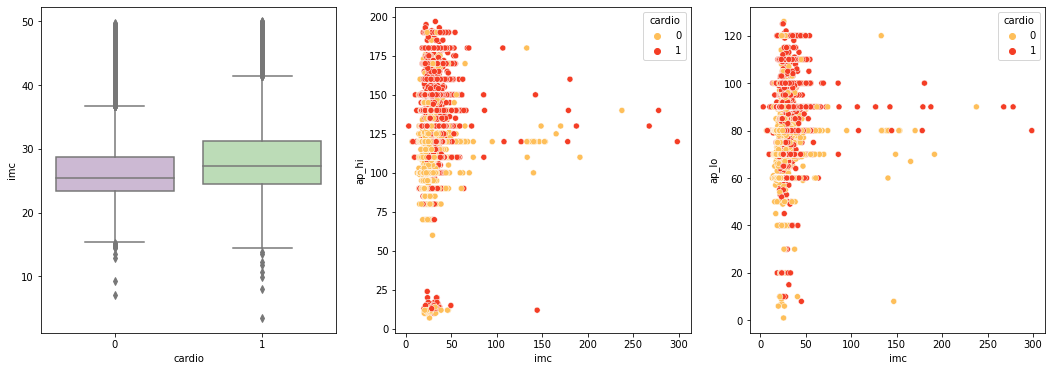

In [38]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
aux = df1[(df1['imc']<50)]
sns.boxplot(x='cardio', y='imc', data=aux, palette="PRGn")

plt.subplot(1,3,2)
sns.scatterplot(x='imc', y='ap_hi', hue='cardio', data=df1,palette="YlOrRd" )

plt.subplot(1,3,3)
sns.scatterplot(x='imc', y='ap_lo', hue='cardio', data=df1, palette="YlOrRd");

**Anotações Importantes**

- Quem tem problema no coração tem o IMC mais alto em média.
- Quem tem problema no coração parece ter uma pressão alta maior.

### Distribuição do IMC

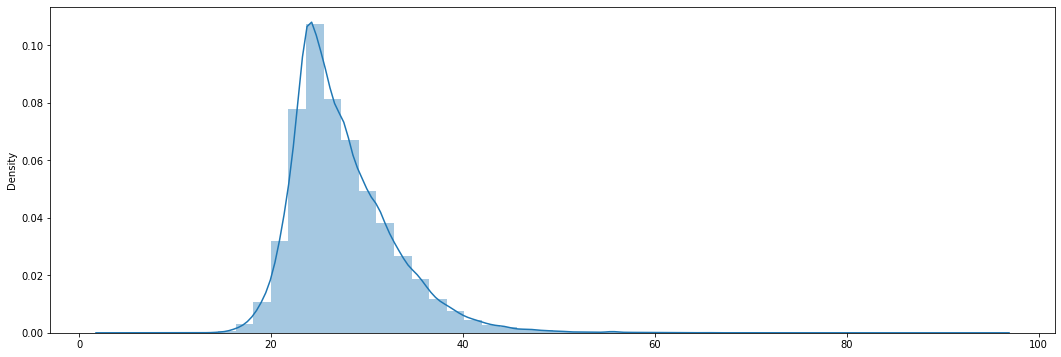

In [39]:
aux = df1[(df1['imc']<100)]
plt.figure(figsize=(18,6))
sns.distplot(x=aux['imc'], kde=True);

### 3.1.14 - Nível de Obesidade

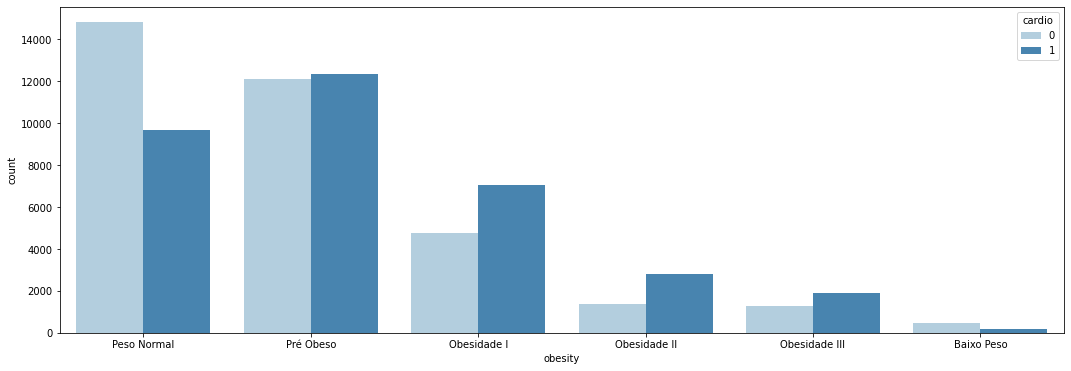

In [40]:
plt.figure(figsize=(18,6))
sns.countplot(x='obesity', hue='cardio', data=df1, palette='Blues',
             order = df1['obesity'].value_counts().index);

### Boxplot Nivel Obesidade

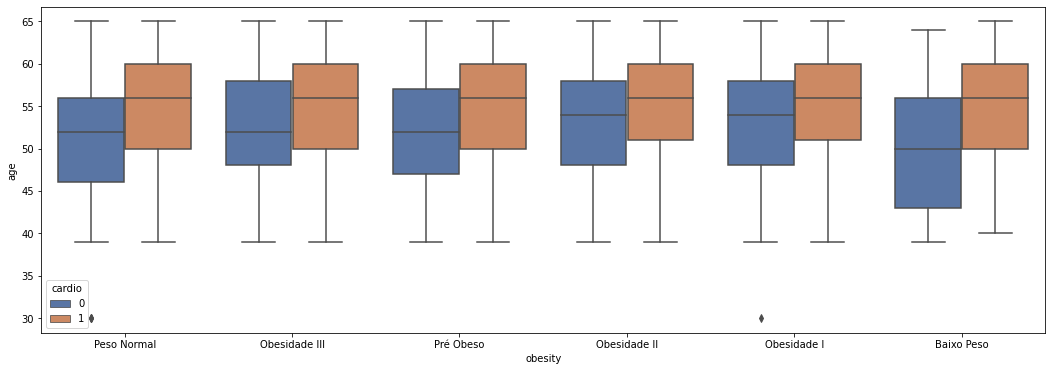

In [41]:
plt.figure(figsize=(18,6))
sns.boxplot(x='obesity', y='age', hue='cardio',data=df1, palette='deep');

**Anotações Importantes**

- Independente do nível de obesidade, quem teve mais problemas cardíacos são sempre pessoas de mais idade em media.

### 3.2 - Distribuição das variáveis

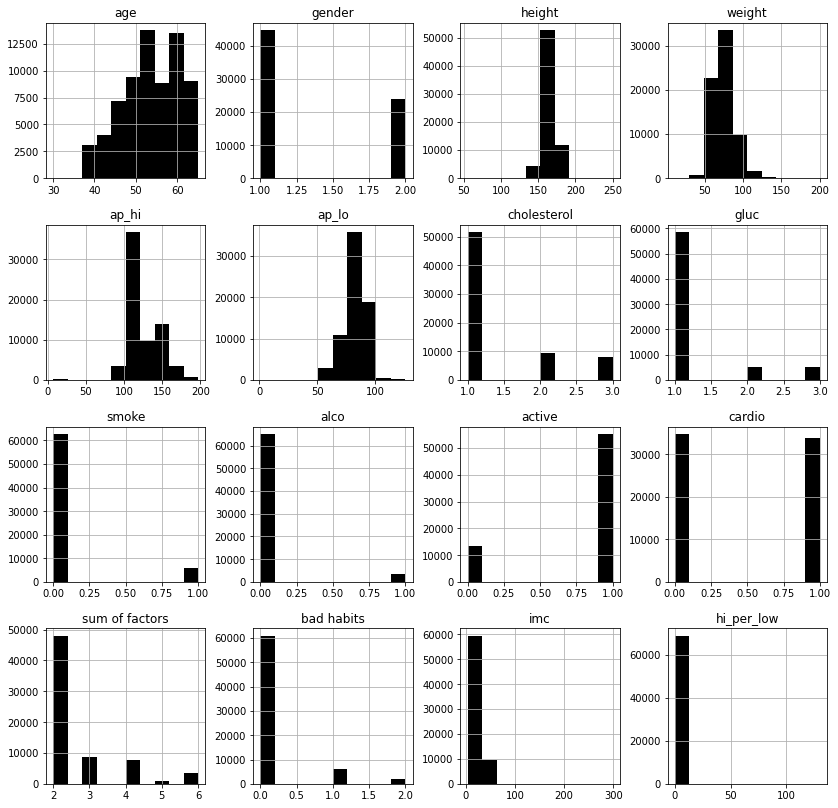

In [42]:
df2 = df1.drop(['id'], axis=1)
fig = plt.figure(figsize=(14,14))
ax = fig.gca()
df2.hist(ax=ax, color='black');

## 3.2 Análise Bivariada

**H1 -** Pessoas com mais de 60 anos tem duas vezes mais chances de ter problema no coração do que uma pessoa com menos de 60 anos.

**Falso** - Pessoas com mais de 60 anos tem em média sete vezes mais chances de ter problemas no coração.

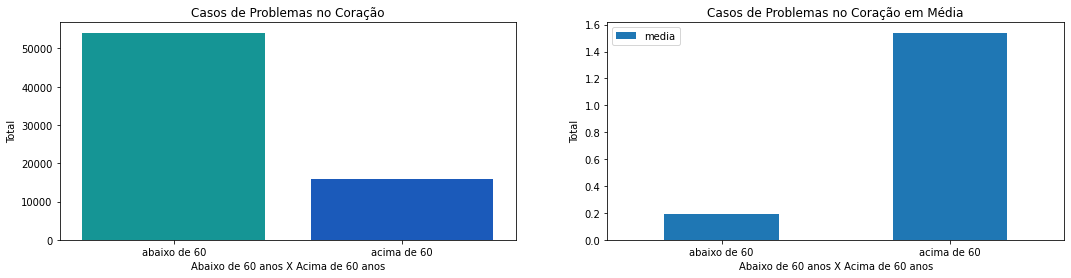

In [43]:
df['faixa_etaria'] = df['age'].apply(lambda x: 'acima de 60' if x >= 60 else 'abaixo de 60')
aux = df[['faixa_etaria', 'cardio']].groupby('faixa_etaria').count().reset_index()

hue1 = df[(df['faixa_etaria']=='acima de 60') & (df['cardio']==1)].shape[0]
hue2 = df[(df['faixa_etaria']=='abaixo de 60') & (df['cardio']==1)].shape[0]

hue = pd.DataFrame([hue1,hue2])
aux = pd.concat([aux, hue], axis=1)

aux['media'] = aux[0]/aux['cardio']
aux = aux[['faixa_etaria', 'media']]
aux.set_index('faixa_etaria',inplace=True)
fig, ax = plt.subplots(1, 2, figsize=(18,4))
aux.plot.bar(ax=ax[1]);
ax[1].set_title('Casos de Problemas no Coração em Média')
ax[1].set_xlabel('Abaixo de 60 anos X Acima de 60 anos')
plt.xticks(rotation = 0)
ax[1].set_ylabel('Total');

sns.countplot(x='faixa_etaria', data=df, palette='winter_r', ax=ax[0]);
ax[0].set_title('Casos de Problemas no Coração')
ax[0].set_xlabel('Abaixo de 60 anos X Acima de 60 anos')
ax[0].set_ylabel('Total');

**H2 -** Em média, um gênero tem mais chances de ter problema no coração do que o outro.

**Falso** - Homens e mulheres tem a mesma chance de ter problemas no coração.

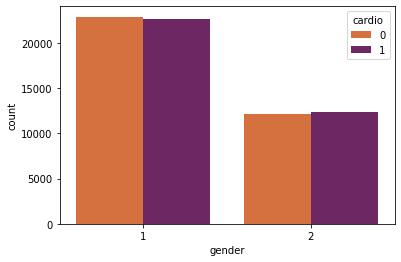

In [44]:
sns.countplot(x='gender', hue='cardio', data=df, palette='inferno_r');

**H3 -** Pressão alta acima de 140 aumenta duas vezes o risco de ter problema no coração.

**Falso** - Pressão alta acima de 140 aumenta três vezes o risco de ter problemas no coração.

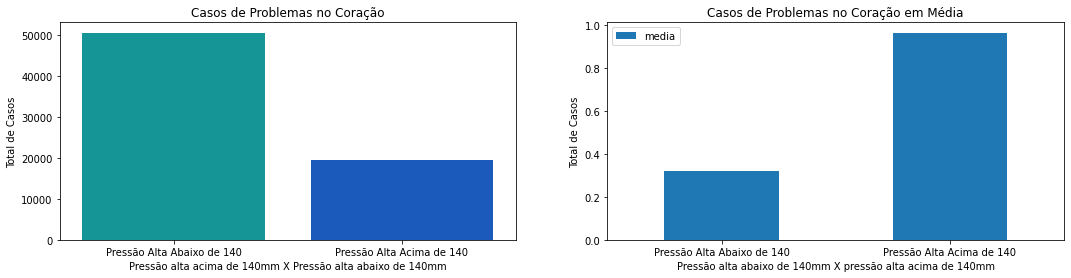

In [45]:
df['faixa_ap_hi'] = df['ap_hi'].apply(lambda x: 'Pressão Alta Acima de 140' if x >= 140 else 'Pressão Alta Abaixo de 140')
aux = df[['faixa_ap_hi', 'cardio']].groupby('faixa_ap_hi').count().reset_index()

hue1 = df[(df['faixa_ap_hi']=='Pressão Alta Acima de 140') & (df['cardio']==1)].shape[0]
hue2 = df[(df['faixa_ap_hi']=='Pressão Alta Abaixo de 140') & (df['cardio']==1)].shape[0]

hue = pd.DataFrame([hue1,hue2])
aux = pd.concat([aux, hue], axis=1)

aux['media'] = aux[0]/aux['cardio']
aux = aux[['faixa_ap_hi', 'media']]
aux.set_index('faixa_ap_hi',inplace=True)
fig, ax = plt.subplots(1, 2, figsize=(18,4))
aux.plot.bar(ax=ax[1]);
ax[1].set_title('Casos de Problemas no Coração em Média')
ax[1].set_xlabel('Pressão alta abaixo de 140mm X pressão alta acima de 140mm')
plt.xticks(rotation = 0)
ax[1].set_ylabel('Total de Casos');

sns.countplot(x='faixa_ap_hi', data=df, palette='winter_r', ax=ax[0]);
ax[0].set_title('Casos de Problemas no Coração')
ax[0].set_xlabel('Pressão alta acima de 140mm X Pressão alta abaixo de 140mm')
ax[0].set_ylabel('Total de Casos');

**H4 -** Pressão baixa acima de 80 aumenta duas vezes o risco de ter problema no coração.

**Falso** - Em média, a maioria dos casos de problema no coração é em quem tem uma pressão baixa abaixo de 80mm.

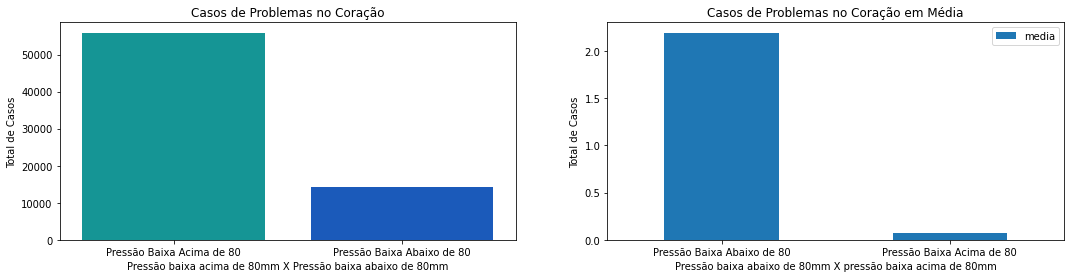

In [46]:
df['faixa_ap_lo'] = df['ap_lo'].apply(lambda x: 'Pressão Baixa Acima de 80' if x >= 80 else 'Pressão Baixa Abaixo de 80')
aux = df[['faixa_ap_lo', 'cardio']].groupby('faixa_ap_lo').count().reset_index()

hue1 = df[(df['faixa_ap_lo']=='Pressão Baixa Acima de 80') & (df['cardio']==1)].shape[0]
hue2 = df[(df['faixa_ap_lo']=='Pressão Baixa Abaixo de 80') & (df['cardio']==1)].shape[0]

hue = pd.DataFrame([hue1,hue2])
aux = pd.concat([aux, hue], axis=1)

aux['media'] = aux[0]/aux['cardio']
aux = aux[['faixa_ap_lo', 'media']]
aux.set_index('faixa_ap_lo',inplace=True)
fig, ax = plt.subplots(1, 2, figsize=(18,4))
aux.plot.bar(ax=ax[1]);
ax[1].set_title('Casos de Problemas no Coração em Média')
ax[1].set_xlabel('Pressão baixa abaixo de 80mm X pressão baixa acima de 80mm')
plt.xticks(rotation = 0)
ax[1].set_ylabel('Total de Casos');

sns.countplot(x='faixa_ap_lo', data=df, palette='winter_r', ax=ax[0]);
ax[0].set_title('Casos de Problemas no Coração')
ax[0].set_xlabel('Pressão baixa acima de 80mm X Pressão baixa abaixo de 80mm')
ax[0].set_ylabel('Total de Casos');

**H5 - Colesterol alto é um fator importante para problemas no coração.**

## 3.3 - Análise Multivariada

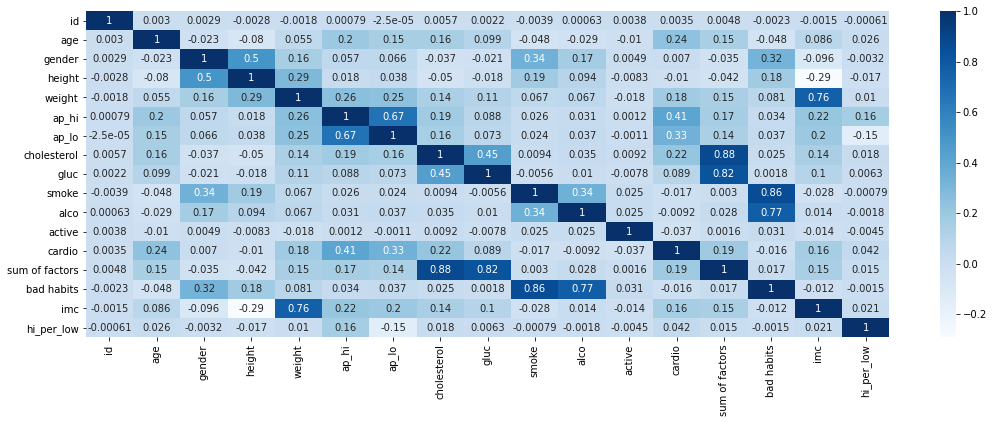

In [47]:
corr = df1.corr()
plt.figure(figsize=(18,6))
sns.heatmap(corr, annot=True, cmap="Blues");

# 4.0 - Remoção de Outlier

In [48]:
mediana_ap_lo = df1['ap_lo'].median()
std_ap_lo = df1['ap_lo'].std()

print('O corte inferior da ap_lo {} e o corte superior {}'.format(mediana_ap_lo - (3*std_ap_lo),mediana_ap_lo + (3*std_ap_lo)))

mediana_ap_hi = df1['ap_hi'].median()
std_ap_hi = df1['ap_hi'].std()

print('O corte inferior da ap_hi {} e o corte superior {}'.format(mediana_ap_hi - (3*std_ap_hi),mediana_ap_hi + (3*std_ap_hi)))

O corte inferior da ap_lo 51.66738212632489 e o corte superior 108.3326178736751
O corte inferior da ap_hi 68.21193363125991 e o corte superior 171.7880663687401


In [49]:
#df1 = df1[(df1['ap_hi']>85) & (df1['ap_hi']<160)]
#df1 = df1[(df1['ap_lo']>60) & (df1['ap_lo']<100)]
#df1 = df1[(df1['weight']>40)]

# 5.0 - Preparação dos Dados

In [50]:
df1.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio',
       'sum of factors', 'bad habits', 'influence comorbid activities',
       'influence bad habits activities', 'imc', 'obesity', 'hi_per_low'],
      dtype='object')

In [51]:
X = df1.drop(['cardio', 'id'], axis=1)
y = df1['cardio']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [53]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [54]:
df_train1 = df_train.copy()
df_test1 = df_test.copy()

In [55]:
df_train1.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'sum of factors', 'bad habits',
       'influence comorbid activities', 'influence bad habits activities',
       'imc', 'obesity', 'hi_per_low', 'cardio'],
      dtype='object')

## 4.1 - Standardization Dados de Treino

In [56]:
ss_height = StandardScaler()
ss_weight = StandardScaler()
ss_ap_hi = StandardScaler()
ss_ap_lo = StandardScaler()
ss_imc = StandardScaler()
ss_hi_per_low = StandardScaler()

df_train1['ap_hi'] = ss_ap_hi.fit_transform(df_train1[['ap_hi']].values)
df_train1['ap_lo'] = ss_ap_lo.fit_transform(df_train1[['ap_lo']].values)
df_train1['height'] = ss_height.fit_transform(df_train1[['height']].values)
df_train1['weight'] = ss_weight.fit_transform(df_train1[['weight']].values)
df_train1['imc'] = ss_imc.fit_transform(df_train1[['imc']].values)
df_train1['hi_per_low'] = ss_hi_per_low.fit_transform(df_train1[['hi_per_low']].values)

## 4.2 - Rescalling Dados de Treino

In [57]:
mms_age = MinMaxScaler()

df_train1['age'] = mms_age.fit_transform(df_train1[['age']].values)

## 4.3 - Encoding Dados de Treino

In [58]:
# Frequency encoding - influence comorbid activities
fe_influence_comorbid_activities = df_train1.groupby('influence comorbid activities').size() / len(df_train1) 
df_train1.loc[:, 'influence comorbid activities'] = df_train1['influence comorbid activities'].map(fe_influence_comorbid_activities)

# Frequency encoding - influence bad habits activities
fe_influence_bad_habits_activities = df_train1.groupby('influence bad habits activities').size() / len(df_train1) 
df_train1.loc[:, 'influence bad habits activities'] = df_train1['influence bad habits activities'].map(fe_influence_bad_habits_activities)

# Frequency encoding - obesity
fe_obesity = df_train1.groupby('obesity').size() / len(df_train1) 
df_train1.loc[:, 'obesity'] = df_train1['obesity'].map(fe_obesity)

## 4.4 -  Standardization Dados de Teste

In [59]:
df_test1.loc[:, 'ap_hi'] = ss_ap_hi.transform(df_test1[['ap_hi']].values)

df_test1.loc[:, 'ap_lo'] = ss_ap_lo.transform(df_test1[['ap_lo']].values)

df_test1.loc[:, 'height'] = ss_height.transform(df_test1[['height']].values)

df_test1.loc[:, 'weight'] = ss_weight.transform(df_test1[['weight']].values)

df_test1.loc[:, 'imc'] = ss_weight.transform(df_test1[['imc']].values)

df_test1.loc[:, 'hi_per_low'] = ss_weight.transform(df_test1[['hi_per_low']].values)

## 4.5 - Rescalling Dados de Teste

In [60]:
df_test1.loc[:, 'age'] = mms_age.transform(df_test1[['age']].values)

## 4.6 - Encoding Dados de Teste

In [61]:
df_test1.loc[:, 'influence comorbid activities'] = df_test1['influence comorbid activities'].map(fe_influence_comorbid_activities)

df_test1.loc[:, 'influence bad habits activities'] = df_test1['influence bad habits activities'].map(fe_influence_bad_habits_activities)

df_test1.loc[:, 'obesity'] = df_test1['obesity'].map(fe_obesity)

# 6.0 - Feature Selection

## Feature Importance Random Forest

In [62]:
X_train_feature_importance = df_train1.drop( ['cardio'], axis=1 )
y_train_feature_importance = df_train1['cardio']

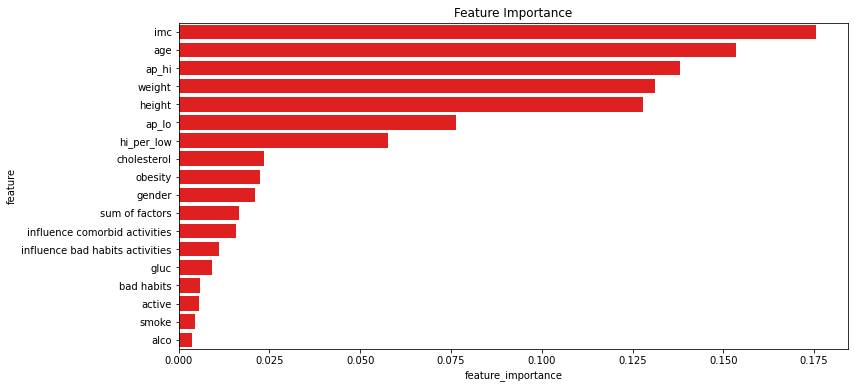

In [63]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_feature_importance, y_train_feature_importance)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train_feature_importance.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='red')\
    .set_title('Feature Importance');

In [64]:
cols_importance_forest = ['imc', 'age', 'ap_hi', 'weight', 'ap_lo', 'height', 'hi_per_low', 'obesity'] 

## Boruta

In [65]:
extra_clf = ExtraTreesClassifier()

In [66]:
boruta = BorutaPy(extra_clf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_feature_importance.values, y_train_feature_importance.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	13


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	13


In [67]:
# gets the ranked list of features
cols_selected = boruta.support_.tolist()
cols_selected_boruta = X_train_feature_importance.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age', 'weight', 'ap_hi', 'ap_lo', 'imc']

In [68]:
cols_boruta = ['age', 'weight', 'ap_hi', 'ap_lo', 'imc']

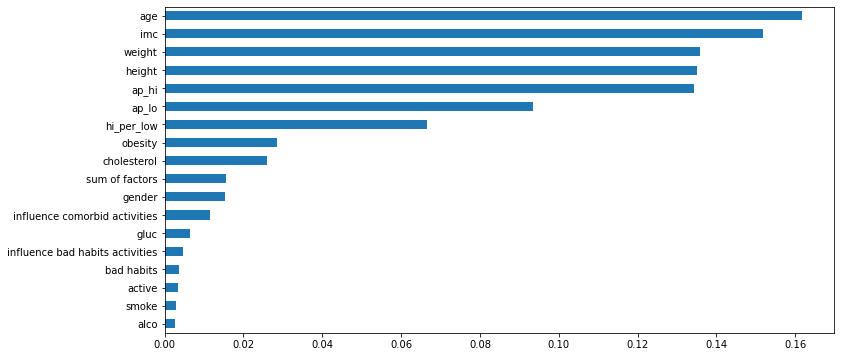

In [69]:
#checking feature importances
extra_clf.fit(X_train_feature_importance, y_train_feature_importance)

feat_importances = pd.Series(extra_clf.feature_importances_, index=X_train_feature_importance.columns)
plt.subplots(figsize=(12,6))
feat_importances.sort_values().plot(kind='barh');

In [70]:
X_train_forest = df_train1[cols_importance_forest]

X_test_forest = df_test1[cols_importance_forest]

# 7.0 - Machine Learning

In [71]:
du = DummyClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
etx = ExtraTreesClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
lgbm = LGBMClassifier()
sgdc = SGDClassifier()

In [72]:
lr_result_forest = ml_error('Regressão Logistica',lr, X_train_forest, y_train)
lr_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,Regressão Logistica,0.718571,0.739228,0.664612,0.699873


In [73]:
dtc_result_forest = ml_error('DecisionTreeClassifier',dtc, X_train_forest, y_train)
dtc_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,DecisionTreeClassifier,0.626481,0.631129,0.586112,0.607738


In [74]:
etx_result_forest = ml_error('ExtraTreesClassifier',etx, X_train_forest, y_train)
etx_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,ExtraTreesClassifier,0.674507,0.678494,0.647866,0.662784


In [75]:
rfc_result_forest = ml_error('RandomForestClassifier',rfc, X_train_forest, y_train)
rfc_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,RandomForestClassifier,0.678888,0.67862,0.664271,0.671334


In [76]:
gbc_result_forest = ml_error('GradientBoostingClassifier',gbc, X_train_forest, y_train)
gbc_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,GradientBoostingClassifier,0.723297,0.738806,0.680169,0.708228


In [77]:
knn_result_forest = ml_error('KNN', knn, X_train_forest, y_train)
knn_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,KNN,0.679343,0.680682,0.660459,0.670388


In [78]:
lgbm_result_forest = ml_error('LGBM', lgbm, X_train_forest, y_train)
lgbm_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,LGBM,0.722951,0.740039,0.676752,0.70692


In [79]:
sgdc_result_forest = ml_error('SGDClassifier', sgdc, X_train_forest, y_train)
sgdc_result_forest

,Model_Name,Acuracia,Precision,Recall,F1
0,SGDClassifier,0.713244,0.75569,0.624697,0.681615


In [80]:
modelling_result_forest = pd.concat([lr_result_forest, dtc_result_forest, etx_result_forest, rfc_result_forest, gbc_result_forest,
                              knn_result_forest, lgbm_result_forest, sgdc_result_forest])
modelling_result_forest.sort_values('F1', ascending=False)

,Model_Name,Acuracia,Precision,Recall,F1
0,GradientBoostingClassifier,0.723297,0.738806,0.680169,0.708228
0,LGBM,0.722951,0.740039,0.676752,0.706920
0,Regressão Logistica,0.718571,0.739228,0.664612,0.699873
0,SGDClassifier,0.713244,0.755690,0.624697,0.681615
0,RandomForestClassifier,0.678888,0.678620,0.664271,0.671334
0,KNN,0.679343,0.680682,0.660459,0.670388
0,ExtraTreesClassifier,0.674507,0.678494,0.647866,0.662784
0,DecisionTreeClassifier,0.626481,0.631129,0.586112,0.607738


In [81]:
classifiers = [LogisticRegression(),GradientBoostingClassifier(), LGBMClassifier()]

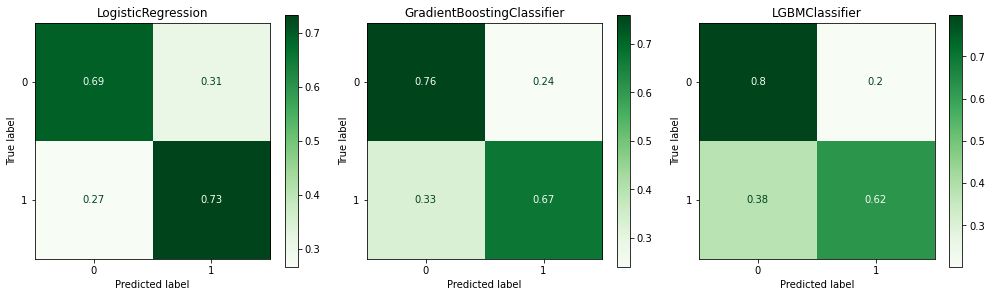

In [82]:
multiple_confusion_matrix(classifiers, X_train_forest, X_test_forest)